In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices
from scipy.stats import ttest_ind, boxcox
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [2]:
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")

In [3]:
all_um_data = pd.read_csv('../Data/UM_data_top_100.csv')

In [4]:
all_um_data = all_um_data.drop(columns=['Unnamed: 0'])

In [5]:
all_um_data['state_code'].fillna('VA', inplace=True)

/var/folders/_4/_j38q0cn0kg4pnd1jf3yvymr0000gn/T/ipykernel_43645/239289188.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_um_data['state_code'].fillna('VA', inplace=True)


In [6]:
all_um_data['Athlete gender'] = all_um_data['Athlete gender'].map({'F': 0, 'M': 1})


In [7]:
all_um_data.rename(columns={'Athlete gender': "Gender"}, inplace=True)
all_um_data.rename(columns={'Average state elevation (feet)': "State_elevation"}, inplace=True)
all_um_data.rename(columns={'true age': "true_age"}, inplace=True)
all_um_data.rename(columns={'Distance (miles)': "distance"}, inplace=True)


In [8]:
all_um_data = all_um_data[all_um_data['true_age'] < 100]

all_um_data = all_um_data[all_um_data['true_age'] > 7]

In [9]:
females = all_um_data[all_um_data['Gender'] == 0]['mph']
males = all_um_data[all_um_data['Gender'] == 1]['mph']

In [10]:
all_um_data['datetime'] = pd.to_datetime(all_um_data['datetime'])

In [11]:
all_um_data['month'] = all_um_data['datetime'].dt.month

In [12]:

# Define the elevation bins
bins = [0, 1000, 2000, 3000, 4000, 5000, float('inf')]
labels = ['0-1000', '1001-2000', '2001-3000', '3001-4000', '4001-5000', '5000+']

# Create a new column 'elevation_group' with the binned data
all_um_data['elevation_group'] = pd.cut(all_um_data['State_elevation'], bins=bins, labels=labels, right=False)

# Now update the features to include 'elevation_group' instead of 'State_elevation'
features = ['Gender', 'true_age', 'distance', 'elevation_group', 'month']
X = pd.get_dummies(all_um_data[features])  # Convert categorical data to dummy variables


In [13]:


# Define features and target

y = all_um_data['mph']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error with Random Forest: {mse}')

# Cross-Validation
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f'Cross-Validated MSE: {-cv_scores.mean()}')


Mean Squared Error with Random Forest: 0.679639258216591
Cross-Validated MSE: 0.6991201918485006


In [14]:
residuals = y_test - y_pred

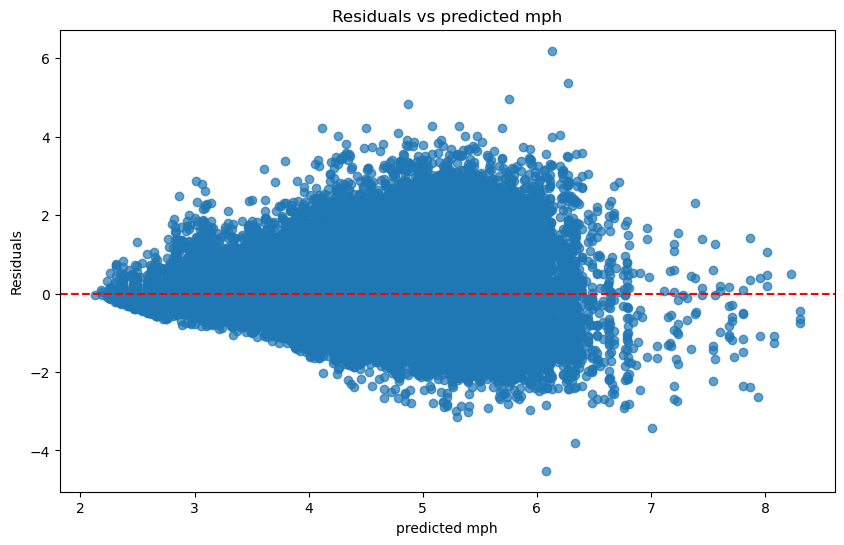

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha = 0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("predicted mph")
plt.ylabel("Residuals")
plt.title('Residuals vs predicted mph')
plt.show()

Feature ranking:
1. Feature distance (0.4521293508792932)
2. Feature true_age (0.1621627589247711)
3. Feature month (0.16153763532394053)
4. Feature elevation_group_5000+ (0.08165738795166501)
5. Feature Gender (0.0652275040382591)
6. Feature elevation_group_3001-4000 (0.034481927832290954)
7. Feature elevation_group_1001-2000 (0.025718557245996115)
8. Feature elevation_group_0-1000 (0.011062012818761307)
9. Feature elevation_group_4001-5000 (0.006022864985022647)
10. Feature elevation_group_2001-3000 (0.0)


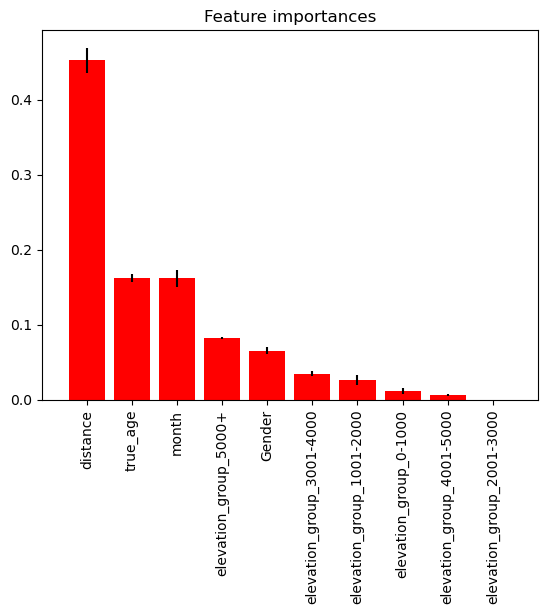

In [16]:

# Extract feature importances
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print(f"{f + 1}. Feature {X.columns[indices[f]]} ({importances[indices[f]]})")

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()


Distance: With the highest importance score (0.355), distance is the most significant predictor of mph. This makes sense as longer distances typically result in slower paces due to increased fatigue.

Elevation: The second most important feature (0.251) is elevation. Races with greater elevation gains are generally more challenging, impacting pace significantly.

Month: Seasonality plays a notable role (0.171). Different months might bring varying weather conditions, which can affect race performance.

Age: Age has a moderate impact (0.158). Performance tends to vary with age, where factors like endurance and recovery can differ between age groups.

Gender: While having the least importance (0.065), gender still contributes to variations in pace. Biological differences can influence race performance.

In [19]:
# New data points
new_data = {
    'Gender': [0, 1],  # 0 for female, 1 for male
    'true_age': [32, 32],
    'distance': [31, 31],
    'State_elevation': [446, 446],
    'month': [6, 6]
}

new_data_df = pd.DataFrame(new_data)

new_data_df['elevation_group'] = pd.cut(new_data_df['State_elevation'], bins=bins, labels=labels, right=False)
new_data_df.drop('State_elevation', axis=1, inplace=True)
new_data_df = pd.get_dummies(new_data_df)

missing_cols = set(X_train.columns) - set(new_data_df.columns)
for col in missing_cols:
    new_data_df[col] = 0
new_data_df = new_data_df[X_train.columns]

# Make predictions on new data
new_predictions = rf_model.predict(new_data_df)
new_data_df['Predicted_mph'] = new_predictions

new_data_df


,Gender,true_age,distance,month,elevation_group_0-1000,elevation_group_1001-2000,elevation_group_2001-3000,elevation_group_3001-4000,elevation_group_4001-5000,elevation_group_5000+,Predicted_mph
0,0,32,31,6,True,False,False,False,False,False,4.224945
1,1,32,31,6,True,False,False,False,False,False,5.030107


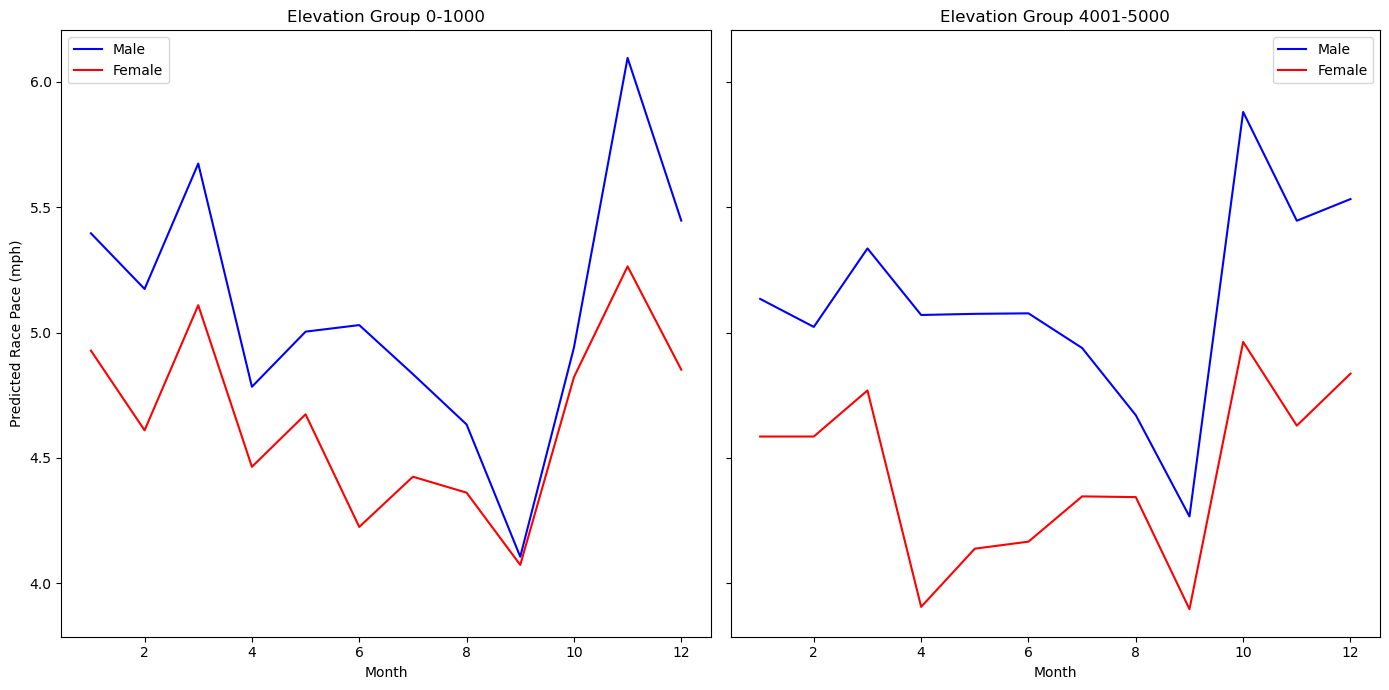

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the elevation bins and labels
bins = [0, 1000, 2000, 3000, 4000, 5000, float('inf')]
labels = ['0-1000', '1001-2000', '2001-3000', '3001-4000', '4001-5000', '5000+']

# Prepare data for predictions
def prepare_data(elevation_group, age=32):
    months = np.arange(1, 13)
    data_male = pd.DataFrame({
        'Gender': [1]*12,
        'true_age': [age]*12,
        'distance': [31]*12,
        'elevation_group': [elevation_group]*12,
        'month': months
    })
    data_female = pd.DataFrame({
        'Gender': [0]*12,
        'true_age': [age]*12,
        'distance': [31]*12,
        'elevation_group': [elevation_group]*12,
        'month': months
    })

    # Convert categorical data to dummy variables
    data_male = pd.get_dummies(data_male)
    data_female = pd.get_dummies(data_female)
    
    # Ensure the new DataFrames have the same columns as the training data
    missing_cols_male = set(X_train.columns) - set(data_male.columns)
    missing_cols_female = set(X_train.columns) - set(data_female.columns)
    for col in missing_cols_male:
        data_male[col] = 0
    for col in missing_cols_female:
        data_female[col] = 0
    data_male = data_male[X_train.columns]
    data_female = data_female[X_train.columns]
    
    return data_male, data_female

# Prepare data for selected elevation groups
data_male_group_1, data_female_group_1 = prepare_data(elevation_group='0-1000')
data_male_group_6, data_female_group_6 = prepare_data(elevation_group='4001-5000')

# Predict for selected elevation groups
pred_male_group_1 = rf_model.predict(data_male_group_1)
pred_female_group_1 = rf_model.predict(data_female_group_1)
pred_male_group_6 = rf_model.predict(data_male_group_6)
pred_female_group_6 = rf_model.predict(data_female_group_6)

# Create subplots with shared y-axis
fig, axs = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

# Plot for elevation group 0-1000
axs[0].plot(data_male_group_1['month'], pred_male_group_1, label='Male', color='blue')
axs[0].plot(data_female_group_1['month'], pred_female_group_1, label='Female', color='red')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Predicted Race Pace (mph)')
axs[0].set_title('Elevation Group 0-1000')
axs[0].legend()

# Plot for elevation group 5000+
axs[1].plot(data_male_group_6['month'], pred_male_group_6, label='Male', color='blue')
axs[1].plot(data_female_group_6['month'], pred_female_group_6, label='Female', color='red')
axs[1].set_xlabel('Month')
axs[1].set_title('Elevation Group 4001-5000')
axs[1].legend()

plt.tight_layout()
plt.show()


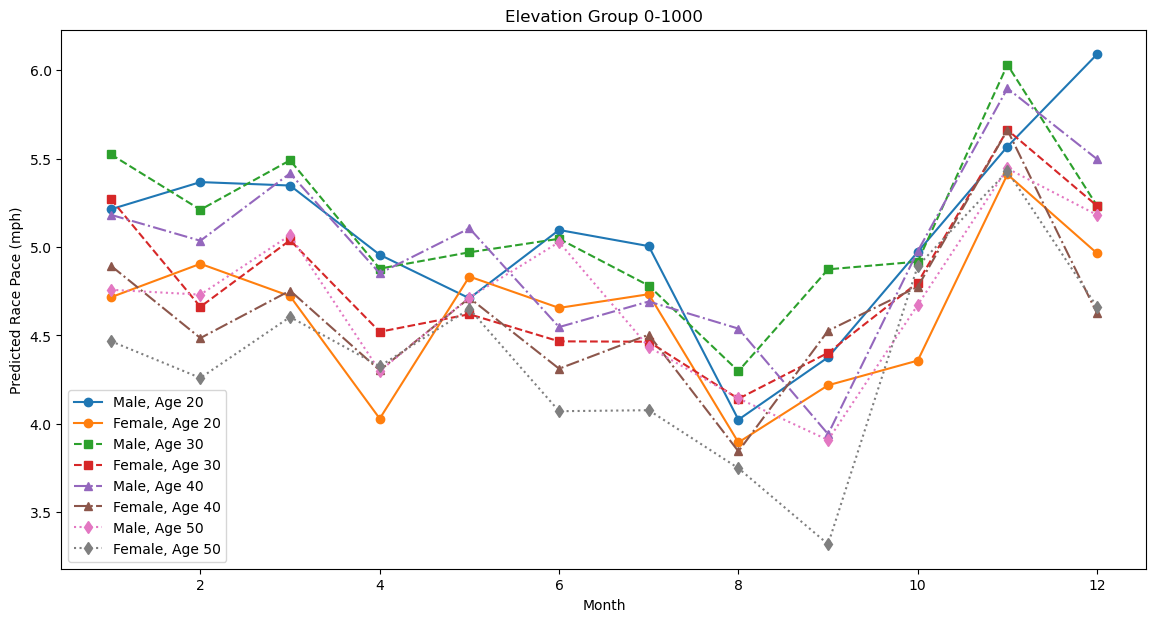

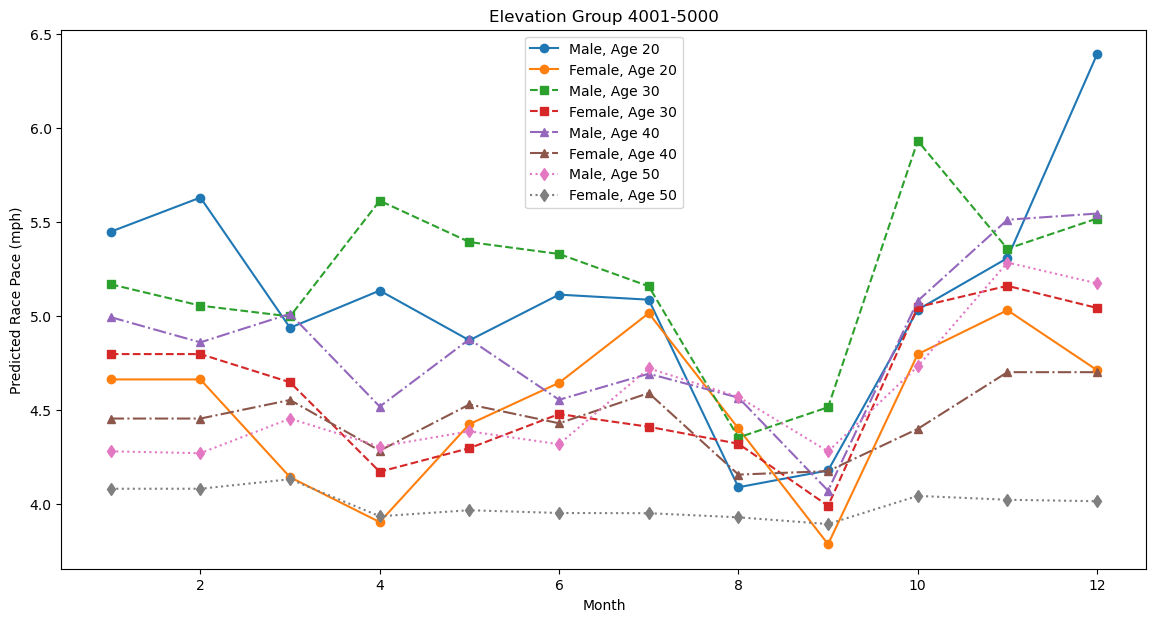

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the elevation bins and labels
bins = [0, 1000, 2000, 3000, 4000, 5000, float('inf')]
labels = ['0-1000', '1001-2000', '2001-3000', '3001-4000', '4001-5000', '5000+']

# Prepare data for predictions
def prepare_data2(elevation_group, ages=[20, 30, 40, 50]):
    months = np.arange(1, 13)
    data = []
    for age in ages:
        data_male = pd.DataFrame({
            'Gender': [1]*12,
            'true_age': [age]*12,
            'distance': [31]*12,
            'elevation_group': [elevation_group]*12,
            'month': months
        })
        data_female = pd.DataFrame({
            'Gender': [0]*12,
            'true_age': [age]*12,
            'distance': [31]*12,
            'elevation_group': [elevation_group]*12,
            'month': months
        })
        
        # Convert categorical data to dummy variables
        data_male = pd.get_dummies(data_male)
        data_female = pd.get_dummies(data_female)
        
        # Ensure the new DataFrames have the same columns as the training data
        missing_cols_male = set(X_train.columns) - set(data_male.columns)
        missing_cols_female = set(X_train.columns) - set(data_female.columns)
        for col in missing_cols_male:
            data_male[col] = 0
        for col in missing_cols_female:
            data_female[col] = 0
        data_male = data_male[X_train.columns]
        data_female = data_female[X_train.columns]
        
        data.append((data_male, data_female, age))
    
    return data

# Prepare data for selected elevation groups
data_group_1 = prepare_data2(elevation_group='0-1000')
data_group_6 = prepare_data2(elevation_group='4001-5000')

# Function to plot predictions
def plot_predictions2(data, elevation_group):
    plt.figure(figsize=(14, 7))
    styles = ['-', '--', '-.', ':']
    markers = ['o', 's', '^', 'd']
    
    for (data_male, data_female, age), style, marker in zip(data, styles, markers):
        pred_male = rf_model.predict(data_male)
        pred_female = rf_model.predict(data_female)
        
        plt.plot(data_male['month'], pred_male, label=f'Male, Age {age}', linestyle=style, marker=marker)
        plt.plot(data_female['month'], pred_female, label=f'Female, Age {age}', linestyle=style, marker=marker)
    
    plt.xlabel('Month')
    plt.ylabel('Predicted Race Pace (mph)')
    plt.title(f'Elevation Group {elevation_group}')
    plt.legend()
    plt.show()

# Plot for elevation groups
plot_predictions2(data_group_1, elevation_group='0-1000')
plot_predictions2(data_group_6, elevation_group='4001-5000')


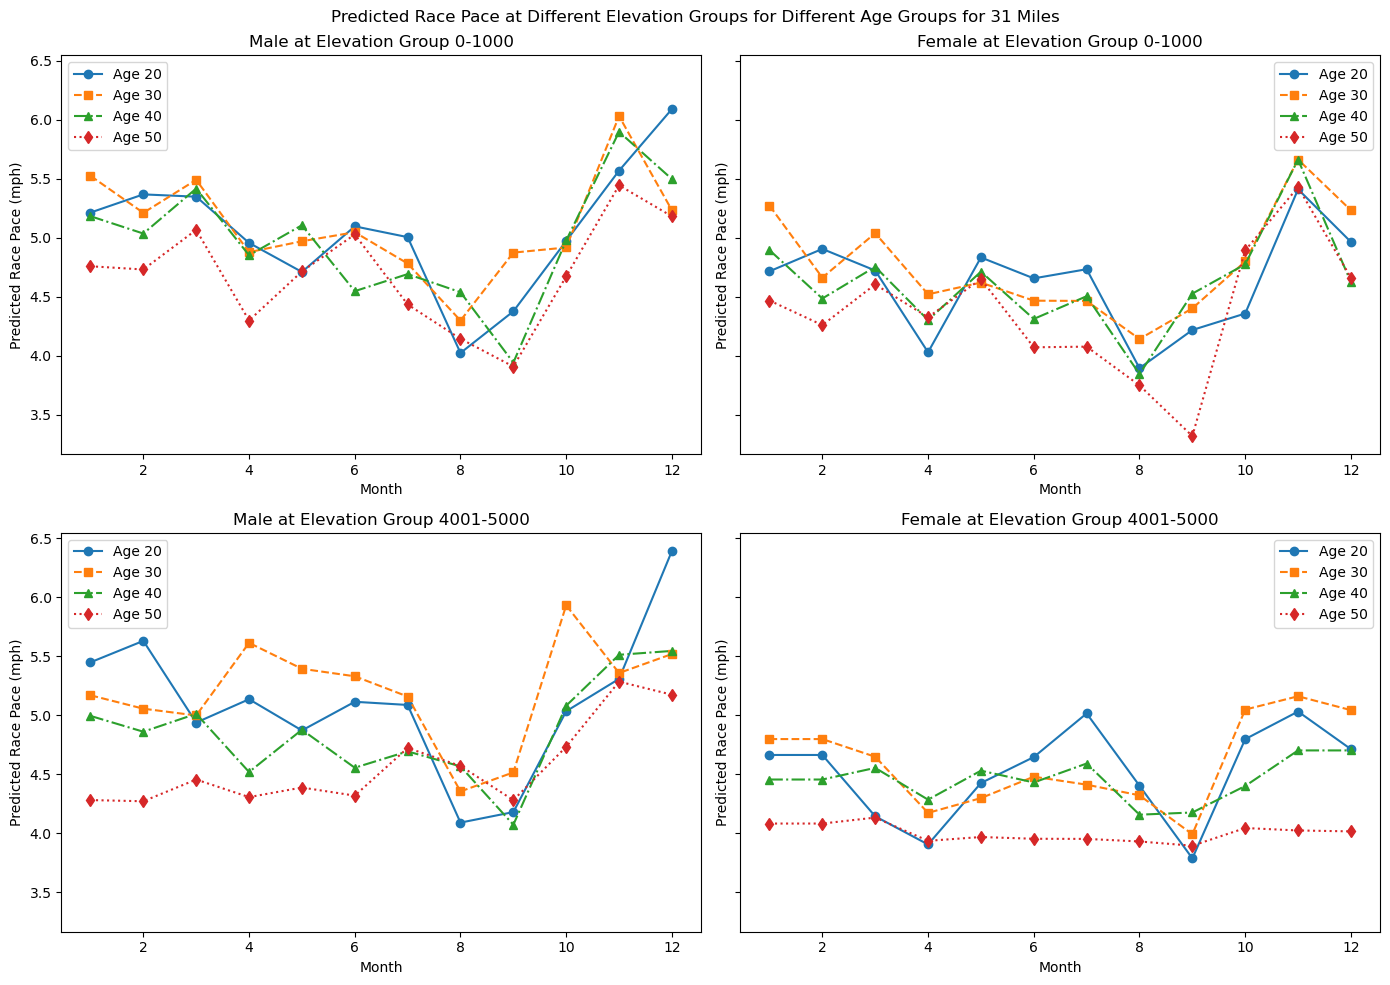

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the elevation bins and labels
bins = [0, 1000, 2000, 3000, 4000, 5000, float('inf')]
labels = ['0-1000', '1001-2000', '2001-3000', '3001-4000', '4001-5000', '5000+']

# Prepare data for predictions
def prepare_data2(elevation_group, ages=[20, 30, 40, 50]):
    months = np.arange(1, 13)
    data = []
    for age in ages:
        data_male = pd.DataFrame({
            'Gender': [1]*12,
            'true_age': [age]*12,
            'distance': [31]*12,
            'elevation_group': [elevation_group]*12,
            'month': months
        })
        data_female = pd.DataFrame({
            'Gender': [0]*12,
            'true_age': [age]*12,
            'distance': [31]*12,
            'elevation_group': [elevation_group]*12,
            'month': months
        })
        
        # Convert categorical data to dummy variables
        data_male = pd.get_dummies(data_male)
        data_female = pd.get_dummies(data_female)
        
        # Ensure the new DataFrames have the same columns as the training data
        missing_cols_male = set(X_train.columns) - set(data_male.columns)
        missing_cols_female = set(X_train.columns) - set(data_female.columns)
        for col in missing_cols_male:
            data_male[col] = 0
        for col in missing_cols_female:
            data_female[col] = 0
        data_male = data_male[X_train.columns]
        data_female = data_female[X_train.columns]
        
        data.append((data_male, data_female, age))
    
    return data

# Prepare data for selected elevation groups
data_group_1 = prepare_data2(elevation_group='0-1000')
data_group_6 = prepare_data2(elevation_group='4001-5000')

# Function to plot predictions
def plot_predictions2(data, elevation_group, ax, gender):
    styles = ['-', '--', '-.', ':']
    markers = ['o', 's', '^', 'd']
    for (data_male, data_female, age), style, marker in zip(data, styles, markers):
        if gender == 'male':
            pred = rf_model.predict(data_male)
            ax.plot(data_male['month'], pred, label=f'Age {age}', linestyle=style, marker=marker)
        else:
            pred = rf_model.predict(data_female)
            ax.plot(data_female['month'], pred, label=f'Age {age}', linestyle=style, marker=marker)
    
    ax.set_xlabel('Month')
    ax.set_ylabel('Predicted Race Pace (mph)')
    ax.set_title(f'{gender.capitalize()} at Elevation Group {elevation_group}')
    ax.legend()

# Create subplots with shared y-axis
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
fig.suptitle('Predicted Race Pace at Different Elevation Groups for Different Age Groups for 31 Miles')

# Plot for males and females at both elevation groups
plot_predictions2(data_group_1, elevation_group='0-1000', ax=axs[0, 0], gender='male')
plot_predictions2(data_group_1, elevation_group='0-1000', ax=axs[0, 1], gender='female')
plot_predictions2(data_group_6, elevation_group='4001-5000', ax=axs[1, 0], gender='male')
plot_predictions2(data_group_6, elevation_group='4001-5000', ax=axs[1, 1], gender='female')

plt.tight_layout()
plt.show()


Temperature and Air Density: Higher elevations have thinner and colder air, which might reduce the body's ability to cool itself efficiently. However, in colder months, the temperature difference between high and low elevations may be less pronounced, creating more similar and potentially more favorable running conditions at higher elevations.

Training Adaptations: Athletes who train at higher elevations may develop physiological adaptations such as increased red blood cell count and improved oxygen utilization. These adaptations can enhance performance, especially in colder months when the body isn't as stressed by heat.

Terrain and Conditions: The terrain at higher elevations might be more stable or predictable in colder months, with fewer temperature and weather fluctuations compared to lower elevations, potentially making it easier to maintain a consistent running pace.

Age Impact: Younger runners (ages 20 and 30) consistently perform better than older runners (ages 40 and 50) across all conditions, indicating age as a significant factor in race performance.

Elevation Effect: Higher elevation seems to have a more substantial impact on performance, with greater differences observed between age groups and noticeable dips during colder months.

Gender Differences: Males generally have a faster predicted pace than females, but the relative performance trends across age groups and months remain similar for both genders.

Seasonal Variation: Colder months appear to affect performance more significantly at higher elevations, highlighting the combined impact of elevation and seasonal conditions on race pace.

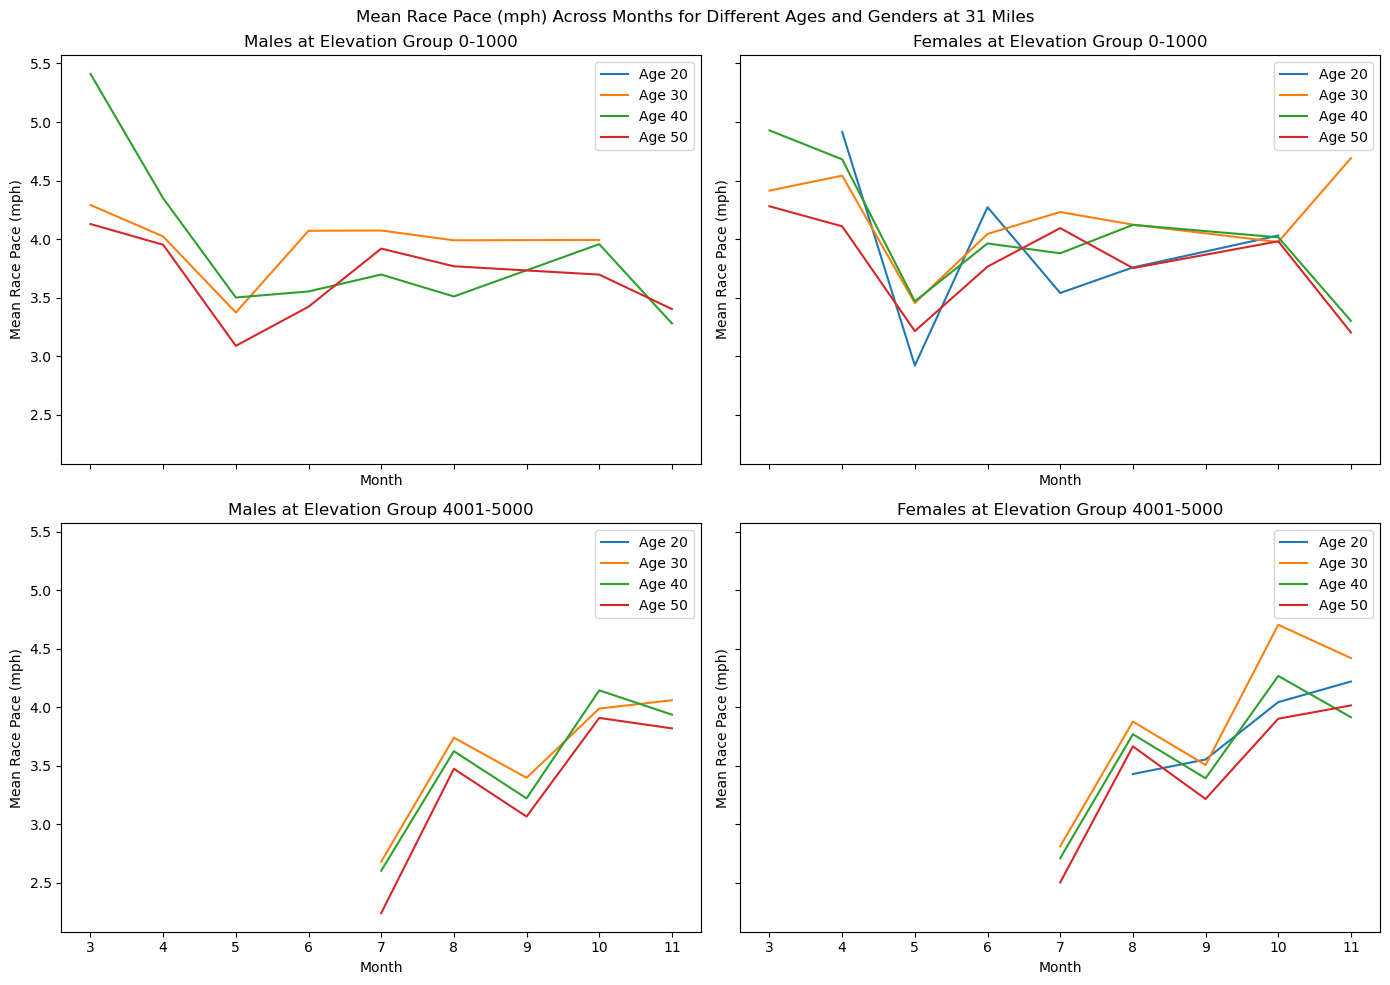

In [41]:


# Define the elevation bins and labels
bins = [0, 1000, 2000, 3000, 4000, float('inf')]
labels = ['0-1000', '1001-2000', '2001-3000', '3001-4000', '4000+']

# Create a new column for elevation groups
all_um_data['elevation_group'] = pd.cut(all_um_data['State_elevation'], bins=bins, labels=labels, right=False)

# Filter the data for the desired conditions and calculate mean race pace
def mean_race_pace(elevation_group, gender, distance=31):
    filtered_data = all_um_data[(all_um_data['elevation_group'] == elevation_group) & 
                                (all_um_data['Gender'] == gender) & 
                                (all_um_data['distance'] == distance)]
    mean_pace = filtered_data.groupby(['true_age', 'month'])['mph'].mean().reset_index()
    return mean_pace

# Calculate mean race pace for elevation groups '0-1000' and '5000+' for both genders
mean_group_1_male = mean_race_pace(elevation_group='0-1000', gender=0, distance=100)
mean_group_1_female = mean_race_pace(elevation_group='0-1000', gender=1, distance=100)
mean_group_6_male = mean_race_pace(elevation_group='4000+', gender=0, distance=100)
mean_group_6_female = mean_race_pace(elevation_group='4000+', gender=1, distance=100)

# Plot results
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
fig.suptitle('Mean Race Pace (mph) Across Months for Different Ages and Genders at 31 Miles')

# Plot for elevation group '0-1000', males
for age in [20, 30, 40, 50]:
    age_data = mean_group_1_male[mean_group_1_male['true_age'] == age]
    axs[0, 0].plot(age_data['month'], age_data['mph'], label=f'Age {age}')
axs[0, 0].set_title('Males at Elevation Group 0-1000')
axs[0, 0].legend()

# Plot for elevation group '0-1000', females
for age in [20, 30, 40, 50]:
    age_data = mean_group_1_female[mean_group_1_female['true_age'] == age]
    axs[0, 1].plot(age_data['month'], age_data['mph'], label=f'Age {age}')
axs[0, 1].set_title('Females at Elevation Group 0-1000')
axs[0, 1].legend()

# Plot for elevation group '5000+', males
for age in [20, 30, 40, 50]:
    age_data = mean_group_6_male[mean_group_6_male['true_age'] == age]
    axs[1, 0].plot(age_data['month'], age_data['mph'], label=f'Age {age}')
axs[1, 0].set_title('Males at Elevation Group 4001-5000')
axs[1, 0].legend()

# Plot for elevation group '5000+', females
for age in [20, 30, 40, 50]:
    age_data = mean_group_6_female[mean_group_6_female['true_age'] == age]
    axs[1, 1].plot(age_data['month'], age_data['mph'], label=f'Age {age}')
axs[1, 1].set_title('Females at Elevation Group 4001-5000')
axs[1, 1].legend()

# Set common labels
for ax in axs.flat:
    ax.set(xlabel='Month', ylabel='Mean Race Pace (mph)')

plt.tight_layout()
plt.show()
